In [1]:
from juliacall import Main as jl, convert as jlconvert  # type: ignore

jl.seval("import Pkg")
jl.seval('Pkg.add("MixedModels")')
jl.seval('Pkg.add("DataFrames")')
jl.seval("using MixedModels")
jl.seval("using DataFrames")


def run_model(df, formula):
    """pd_to_df is a Julia function that takes a pd.DataFrame and turns it into a Julia DataFrame"""
    jl.j_df = jlconvert(jl.PyTable, df)
    jl.seval(f"j_formula = @formula({formula})")
    jl.seval("j_model = fit(MixedModel, j_formula, j_df, progress=false)")
    return jl.j_model


import pandas as pd  # noqa: E402
import seaborn as sns  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
from pathlib import Path  # noqa: E402
import notebooks.notebook_utils as nu  # noqa: E402

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


   Resolving package versions...
  No Changes to `~/miniforge3/envs/decoding/julia_env/Project.toml`
  No Changes to `~/miniforge3/envs/decoding/julia_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/miniforge3/envs/decoding/julia_env/Project.toml`
  No Changes to `~/miniforge3/envs/decoding/julia_env/Manifest.toml`


In [2]:
base_path = Path("../ln_shared_data/onestop/processed/goal_decoding")

(
    eyes_numerical,
    eyes_categorical,
    text,
    metadata,
    session_summary,
    reading_habits,
    readability_metrics,
) = nu.prepare_dataframes(base_path)

Load data from ../ln_shared_data/onestop/processed/ia_data_enriched_360_17092024.csv using pyarrow.
Attempting to load data from ../ln_shared_data/onestop/processed/ia_data_enriched_360_17092024.csv without specifying encoding.


process_onestop_sr_report.preprocessing: INFO     Loaded 2532799 records from ../ln_shared_data/onestop/processed/ia_data_enriched_360_17092024.csv.


In [3]:
model_dfs = {}
for model_name, model_path in nu.models.items():
    trainer = "CondPredBase"
    if model_name in ["Dummy", "LRDiane", "LRAvgDWELL"]:
        trainer = "ML"
    res = pd.read_csv(
        f"../task_decoding/+data=NoReread,+data_path=august06,+model={model_path},+trainer={trainer},trainer.wandb_job_type=hyperparameter_sweep_{model_path}/trial_level_test_results.csv",
        usecols=[
            "subjects",
            "items",
            "fold_index",
            "eval_regime",
            "is_correct",
            "eval_type",
            "label",
            "binary_prediction",
            "prediction_prob",
        ],
    )
    res["subjects"] = res["subjects"].str.lower()
    res["subject_id_without_list"] = res["subjects"].str.split("_").str[1]

    res = nu.merge_dataframes(
        res=res,
        eyes_numerical=eyes_numerical,
        eyes_categorical=eyes_categorical,
        text=text,
        metadata=metadata,
        session_summary=session_summary,
        reading_habits=reading_habits,
        readability_metrics=readability_metrics,
    )
    res["model_name"] = model_name if model_name != "LRAvgDWELL" else "A_LRAvgDWELL"

    res["a_bcd"] = res["abcd_answer"].map({"A": 0, "B": 1, "C": 1, "D": 1})
    res["level_numeric"] = res["level"].map({"Ele": 0, "Adv": 1})
    res["is_correct_05"] = res["is_correct"].replace({0: -0.5, 1: 0.5})

    model_dfs[model_name] = res[res.eval_type == "test"].drop(columns=["eval_type"])

results = pd.concat(model_dfs.values(), ignore_index=True)

In [4]:
res = pd.read_csv("l_e.csv")  # get this from the other notebook
res["subjects"] = res["subjects"].str.lower()
res["subject_id_without_list"] = res["subjects"].str.split("_").str[1]

res = nu.merge_dataframes(
    res=res,
    eyes_numerical=eyes_numerical,
    eyes_categorical=eyes_categorical,
    text=text,
    metadata=metadata,
    session_summary=session_summary,
    reading_habits=reading_habits,
    readability_metrics=readability_metrics,
)
res["model_name"] = "LogisticEnsemble"

res["a_bcd"] = res["abcd_answer"].map({"A": 0, "B": 1, "C": 1, "D": 1})
res["level_numeric"] = res["level"].map({"Ele": 0, "Adv": 1})
res["is_correct_05"] = res["is_correct"].replace({0: -0.5, 1: 0.5})

model_dfs["LogisticEnsemble"] = res[res.eval_type == "test"].drop(columns=["eval_type"])
results = pd.concat(model_dfs.values(), ignore_index=True)

## Confusion Matrix and Classification Report - Not in use

In [5]:
# model_df = model_dfs["RoBERTa-QEye-F"]
# nu.confusion_matrix_by_regime(res=model_df)
# nu.classification_report_by_regime(model_df)

# ROC Curve

dict_keys(['Dummy', 'LRAvgDWELL', 'LRDiane', 'FSE', 'RoBERTa-QEye-W', 'MAG', 'PLMAS', 'Haller RNN', 'BEyeLSTM', 'Eyettention', 'RoBERTa-QEye-F', 'PostFusion'])
Saving figure to figures/ROC_Curves_by_Model_and_Evaluation_Regime.pdf


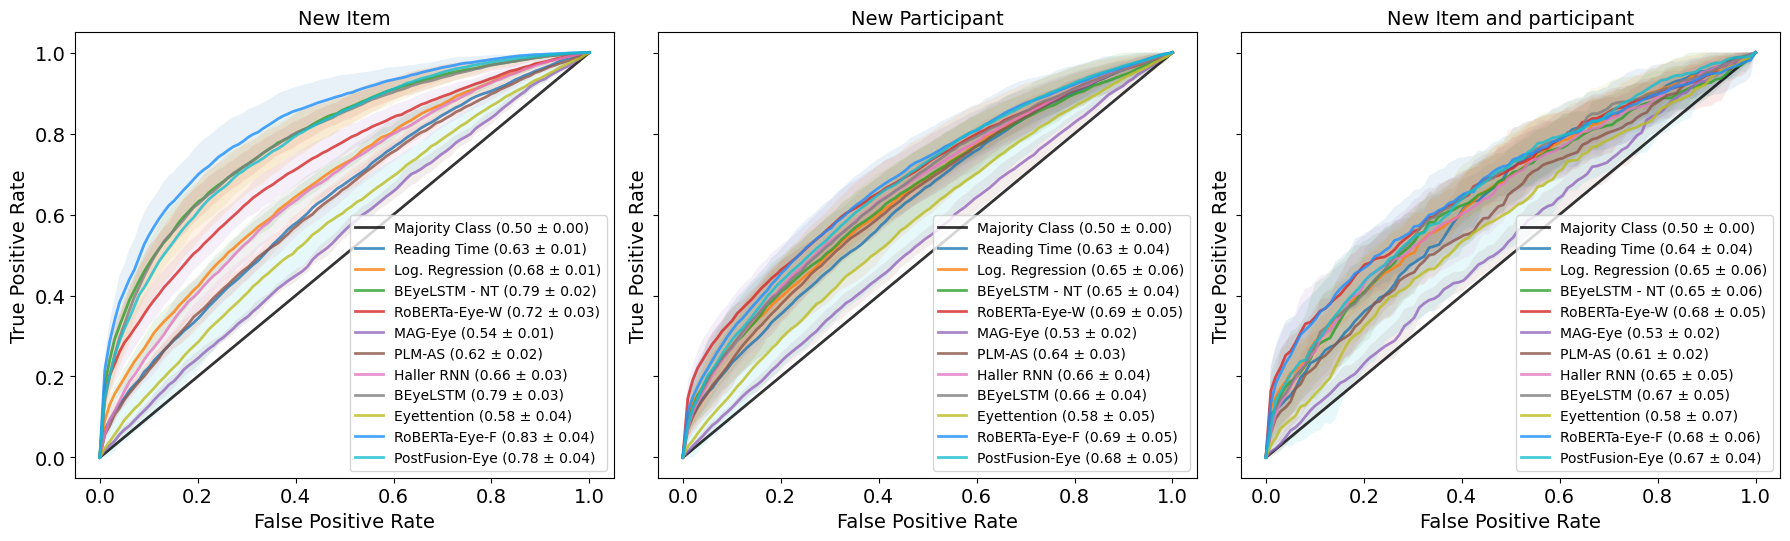

In [30]:
from importlib import reload
reload(nu)
roc_models = model_dfs.copy()
roc_models.pop("LogisticEnsemble")
print(roc_models.keys())
nu.plot_average_roc_curves_with_error_bands(roc_models)

# Metadata Analysis

### The model used

In [7]:
model_df = model_dfs["RoBERTa-QEye-F"]

## Get Coefficients

In [8]:
model_df["unique_paragraph_id_without_level"] = (
    model_df["unique_paragraph_id"].str.replace("Adv", "").str.replace("Ele", "")
)
model_df["aspan_len_rel"] = model_df["aspan_len"] / model_df["paragraph_length"]
model_df['q_difficulty'] = 1-model_df['a_proportion']
model_df.rename(
    columns={
        "IA_DWELL_TIME_After Critical Span": "IA_DWELL_TIME_After_Critical_Span",
        "IA_DWELL_TIME_Before Critical Span": "IA_DWELL_TIME_Before_Critical_Span",
        "IA_DWELL_TIME_In Critical Span": "IA_DWELL_TIME_In_Critical_Span",
    },
    inplace=True,
)
name_mapping = {
    "(Intercept)": "Intercept",
    "trial": r"$\it{Paragraph\ Index}$",
    "aspan_len_rel": "Critical Span Length",
    "paragraph_length": "Paragraph Length",
    "aspan_start_rel": "Critical Span Start Location",
    "a_bcd": "Answered Correctly",
    "level_numeric": "Paragraph Level\n(Advanced / Elementary)",
    "q_difficulty": "Question Difficulty",
    "IA_DWELL_TIME_After_Critical_Span": "Reading Time After Critical Span",
    "IA_DWELL_TIME_Before_Critical_Span": "Reading Time Before Critical Span",
    "IA_DWELL_TIME_In_Critical_Span": "Reading Time In Critical Span",
}
params = list(name_mapping.keys() - set(["(Intercept)"]))
re_cols = [
    "subject_id",
    "unique_paragraph_id_without_level",
    "eval_regime",
]  # TODO NOTE that we are using unique_paragraph_id_without_level instead of unique_paragraph_id right now

is_correct_05 = False
random_effects_structure = "intercept"
standardize_features_flag = True
with_std = True

outcome = nu.get_outcome_variable(is_correct_05)

formula = nu.construct_formula(outcome, params, random_effects_structure)

formula = formula.replace(
    "unique_paragraph_id", "unique_paragraph_id_without_level"
)  # TODO NOTE as well
# formula += " + (1 | fold_index)"
metadata_coefficients = []
for label_ in [0, 1]:
    model_df_input = model_df.loc[
        model_df["label"] == label_, params + re_cols + [outcome] + ["fold_index"]
    ].copy()

    if standardize_features_flag:
        model_df_input = nu.standardize_features(model_df_input, params, with_std)
    # impute nan values in q_difficulty using mean
    model_df_input["q_difficulty"] = model_df_input["q_difficulty"].fillna(
        model_df_input["q_difficulty"].mean()
    )
    model_df_input = nu.remove_nan_values(model_df_input)
    model_df_input = model_df_input.reset_index(drop=True)

    metadata_coeffs = run_model(model_df_input, formula)
    regime = "Gathering" if label_ == 0 else "Hunting"
    print(f"Model coefficients for {regime} trials")
    display(metadata_coeffs)
    metadata_coefficients.append(metadata_coeffs)

Using is_correct as outcome.
Random effects structure: intercept
Formula: is_correct ~ q_difficulty+trial+paragraph_length+level_numeric+aspan_start_rel+IA_DWELL_TIME_Before_Critical_Span+aspan_len_rel+IA_DWELL_TIME_In_Critical_Span+a_bcd+IA_DWELL_TIME_After_Critical_Span + (1 | subject_id) + (1 | unique_paragraph_id) + (1 | eval_regime)
Standardized coefficients with_std=True


Model coefficients for Gathering trials


,Est.,SE,z,p,σ_subject_id,σ_unique_paragraph_id_without_level,σ_eval_regime
(Intercept),0.6755,0.0402,16.81,<1e-62,0.1997,0.0507,0.0638
q_difficulty,0.0035,0.0035,1.00,0.3184,,,
trial,-0.0027,0.0030,-0.91,0.3652,,,
paragraph_length,0.0096,0.0051,1.88,0.0607,,,
level_numeric,0.0046,0.0036,1.27,0.2032,,,
aspan_start_rel,0.0013,0.0045,0.30,0.7662,,,
IA_DWELL_TIME_Before_Critical_Span,0.0263,0.0040,6.54,<1e-10,,,
aspan_len_rel,-0.0036,0.0040,-0.91,0.3617,,,
IA_DWELL_TIME_In_Critical_Span,0.0086,0.0041,2.11,0.0349,,,
a_bcd,0.0008,0.0032,0.25,0.8040,,,


Standardized coefficients with_std=True
Model coefficients for Hunting trials


,Est.,SE,z,p,σ_subject_id,σ_unique_paragraph_id_without_level,σ_eval_regime
(Intercept),0.6672,0.0317,21.06,<1e-97,0.1886,0.0698,0.0475
q_difficulty,0.0084,0.0036,2.34,0.0194,,,
trial,0.0129,0.0030,4.22,<1e-04,,,
paragraph_length,0.0016,0.0059,0.27,0.7900,,,
level_numeric,-0.0093,0.0038,-2.45,0.0142,,,
aspan_start_rel,-0.0063,0.0042,-1.50,0.1341,,,
IA_DWELL_TIME_Before_Critical_Span,-0.0648,0.0039,-16.40,<1e-59,,,
aspan_len_rel,-0.0155,0.0041,-3.79,0.0001,,,
IA_DWELL_TIME_In_Critical_Span,0.0088,0.0039,2.23,0.0259,,,
a_bcd,-0.0064,0.0032,-2.03,0.0419,,,


## Prep coeffs for display

In [9]:
coef_names0 = [c for c in jl.coefnames(metadata_coefficients[0])]
coef_names1 = [c for c in jl.coefnames(metadata_coefficients[1])]
assert coef_names0 == coef_names1
name_mapping = {
    "(Intercept)": "Intercept",
    "trial": "Paragraph Position",
    "aspan_len_rel": "Critical Span Length",
    "paragraph_length": "Paragraph Length",
    "IA_DWELL_TIME_Before_Critical_Span": "Reading Time Before CS",
    "IA_DWELL_TIME_In_Critical_Span": "Reading Time In CS",
    "IA_DWELL_TIME_After_Critical_Span": "Reading Time After CS",
    "aspan_start_rel": "Critical Span Start Location",
    "a_bcd": "Answered Correctly",
    "level_numeric": "Paragraph Level\n(Advanced / Elementary)",
    "q_difficulty": "Question Difficulty",
}
coef_names = [name_mapping[c] for c in coef_names0]


all_coeffs = []
for i, metadata_coeffs in enumerate(metadata_coefficients):
    coeffs_df = pd.DataFrame(
        {
            "Coefficient": [b for b in metadata_coeffs.beta],
            "p-value": [p for p in metadata_coeffs.pvalues],
        },
        index=coef_names,
    )
    coeffs_df["label"] = i
    all_coeffs.append(coeffs_df)
coeffs_df = pd.concat(all_coeffs)

coeffs_df["asterisk"] = coeffs_df.apply(
    lambda row: nu.map_pvalue_to_asterisks(row["p-value"]*10), axis=1
)
coeffs_df = coeffs_df[coeffs_df.index != "Intercept"]
coeffs_df["abs_coefficient"] = coeffs_df["Coefficient"].abs()
# Compute the abs sum of each coefficient name
coeffs_df["abs_sum"] = coeffs_df.groupby(level=0)["abs_coefficient"].transform("sum")

indices_to_check = [
    "Paragraph Position",
    "Answered Correctly",
    "Reading Time Before CS",
    "Reading Time In CS",
    "Reading Time After CS",
]

# Apply the condition using a lambda function
coeffs_df["Type"] = [
    "Subject" if row in indices_to_check else "Paragraph" for row in coeffs_df.index
]

# sort by the abs sum
order_mapping = {
    "Reading Time Before CS": 0,
    "Reading Time In CS": 1,
    "Reading Time After CS": 2,
    "Paragraph Position": 3,
    "Answered Correctly": 4,
    "Paragraph Length": 5,
    "Paragraph Level\n(Advanced / Elementary)": 6,
    "Critical Span Start Location": 7,
    "Critical Span Length": 8,
    "Question Difficulty": 9,
}
coeffs_df["order"] = coeffs_df.index.map(order_mapping)
coeffs_df = coeffs_df.sort_values(by=["order", "label"], ascending=[True, True])
# coeffs_df.drop(columns=["abs_sum"], inplace=True)
coeffs_df

,Coefficient,p-value,label,asterisk,abs_coefficient,abs_sum,Type,order
Reading Time Before CS,0.026298,6.035793e-11,0,***,0.026298,0.091090,Subject,0
Reading Time Before CS,-0.064792,1.799668e-60,1,***,0.064792,0.091090,Subject,0
Reading Time In CS,0.008596,3.491810e-02,0,n.s.,0.008596,0.017351,Subject,1
Reading Time In CS,0.008756,2.592918e-02,1,n.s.,0.008756,0.017351,Subject,1
Reading Time After CS,0.016834,9.121108e-05,0,***,0.016834,0.047239,Subject,2
Reading Time After CS,-0.030405,2.580158e-14,1,***,0.030405,0.047239,Subject,2
Paragraph Position,-0.002736,3.651966e-01,0,n.s.,0.002736,0.015608,Subject,3
Paragraph Position,0.012871,2.418326e-05,1,***,0.012871,0.015608,Subject,3
Answered Correctly,0.000783,8.039893e-01,0,n.s.,0.000783,0.007205,Subject,4
Answered Correctly,-0.006422,4.192896e-02,1,n.s.,0.006422,0.007205,Subject,4


## Coefficients Display

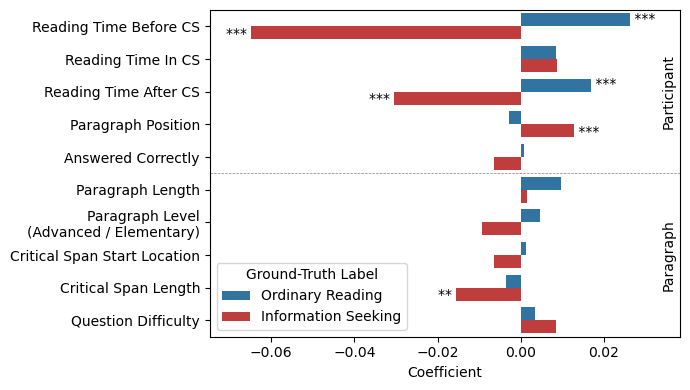

In [10]:
plt.figure(figsize=(7, 4))

# Replace labels for better readability
coeffs_df["label"] = coeffs_df["label"].replace(
    {0: "Ordinary Reading", 1: "Information Seeking"}
)

# Plot the barplot with hue based on the label

palette = {"Ordinary Reading": "tab:blue", "Information Seeking": "tab:red"}

ax = sns.barplot(
    x="Coefficient", y=coeffs_df.index, data=coeffs_df, hue="label", palette=palette
)

prev_row_type = None
# Iterate over the bars to add asterisk annotations
for i, row in enumerate(coeffs_df.itertuples()):
    # Get the value and asterisk for each row
    value = float(row.Coefficient)  # type: ignore
    asterisk = row.asterisk
    asterisk = "" if asterisk == "n.s." else asterisk
    # Calculate the y position for correct placement of the asterisk
    y_pos = i // 2  # Adjust the position for alternating bars due to the hue

    # Determine if we are annotating for "Ordinary Reading" or "Information Seeking"
    if row.label == "Information Seeking":
        y_pos += 0.22  # Slight adjustment to avoid overlap with the bar
    else:
        y_pos -= 0.22  # Adjust for "Ordinary Reading" label

    # Add the asterisk text to the plot
    if value > 0:
        # For positive values, place asterisk to the right of the bar
        ax.text(value, y_pos, f" {asterisk}", va="center", ha="left")
    else:
        # For negative values, place asterisk to the left of the bar
        ax.text(value, y_pos, f"{asterisk} ", va="center", ha="right")

    if prev_row_type == "Subject" and row.Type == "Paragraph":
        # Add a thin horizontal line after the last "Item"
        ax.axhline(y=y_pos - 0.3, color="gray", linestyle="--", linewidth=0.5)
        
        # Get the rightmost x position of the plot
        rightmost_x = coeffs_df["Coefficient"].max()
        right_offset = 0.0075
        # Plot the text vertically next to the right side of the plot
        ax.text(x=rightmost_x + right_offset, y=2, s="Participant", rotation=90, verticalalignment='center')
        ax.text(x=rightmost_x + right_offset, y=7, s="Paragraph", rotation=90, verticalalignment='center')

    prev_row_type = row.Type

# plt x range current +- 0.25
plt.xlim(coeffs_df["Coefficient"].min() - 0.01, coeffs_df["Coefficient"].max() + 0.012)


# Set the label for the y-axis and adjust layout
plt.ylabel("")
plt.tight_layout()

# Add legend title: Ground-Truth Label
plt.legend(title="Ground-Truth Label", loc="best")

# Save the figure as a PNG file
plt.savefig("figures/metadata_coeffs.pdf")

# Show the plot
plt.show()

# Without split into Hunting / Gathering

In [11]:
model_df["unique_paragraph_id_without_level"] = (
    model_df["unique_paragraph_id"].str.replace("Adv", "").str.replace("Ele", "")
)

params = [
    "trial",
    "aspan_len",
    "paragraph_length",
    "IA_DWELL_TIME",
    # "flesch_reading_ease",
    "aspan_start_rel",
    "a_bcd",
    "level_numeric",
    "a_proportion",
]
re_cols = [
    "subject_id",
    "unique_paragraph_id_without_level",
    "eval_regime",
]  # TODO NOTE that we are using unique_paragraph_id_without_level instead of unique_paragraph_id right now

is_correct_05 = False
random_effects_structure = "intercept"
standardize_features_flag = True
with_std = True

outcome = nu.get_outcome_variable(is_correct_05)

formula = nu.construct_formula(outcome, params, random_effects_structure)

formula = formula.replace(
    "unique_paragraph_id", "unique_paragraph_id_without_level"
)  # TODO NOTE as well

metadata_coefficients = []
model_df_input = model_df[params + re_cols + [outcome]].copy()

if standardize_features_flag:
    model_df_input = nu.standardize_features(model_df_input, params, with_std)
model_df_input = nu.remove_nan_values(model_df_input)
model_df_input = model_df_input.reset_index(drop=True)

metadata_coeffs = run_model(model_df_input, formula)
regime = "Gathering" if label_ == 0 else "Hunting"
print(f"Model coefficients for {regime} trials")
display(metadata_coeffs)
metadata_coefficients.append(metadata_coeffs)

Using is_correct as outcome.
Random effects structure: intercept
Formula: is_correct ~ trial+aspan_len+paragraph_length+IA_DWELL_TIME+aspan_start_rel+a_bcd+level_numeric+a_proportion + (1 | subject_id) + (1 | unique_paragraph_id) + (1 | eval_regime)
Standardized coefficients with_std=True
Dropped NaN values coming from columns: ['a_proportion']
Removed 1065 rows out of 36932 total rows.
Model coefficients for Hunting trials


,Est.,SE,z,p,σ_subject_id,σ_unique_paragraph_id_without_level,σ_eval_regime
(Intercept),0.6725,0.0341,19.73,<1e-85,0.2092,0.0264,0.0554
trial,0.0038,0.0022,1.72,0.0856,,,
aspan_len,-0.0074,0.0026,-2.78,0.0054,,,
paragraph_length,0.0096,0.0033,2.93,0.0033,,,
IA_DWELL_TIME,-0.0205,0.0034,-6.10,<1e-08,,,
aspan_start_rel,-0.0071,0.0024,-2.95,0.0031,,,
a_bcd,-0.0033,0.0023,-1.44,0.1509,,,
level_numeric,-0.0005,0.0025,-0.19,0.8468,,,
a_proportion,-0.0059,0.0024,-2.43,0.0150,,,
Residual,0.4086,,,,,,


In [12]:
# coef_names0 = [c for c in jl.coefnames(metadata_coefficients[0])]
# coef_names1 = [c for c in jl.coefnames(metadata_coefficients[1])]
# assert coef_names0 == coef_names1
name_mapping = {
    "(Intercept)": "Intercept",
    "trial": r"$\it{Paragraph\ Index}$",
    "aspan_len": "Critical Span Length",
    "paragraph_length": "Paragraph Length",
    "IA_DWELL_TIME": r"$\it{Reading\ Time}$",
    "aspan_start_rel": "Critical Span Start Location",
    "a_bcd": r"$\it{Answered\ Correctly}$",
    "level_numeric": "Paragraph Level\n(Advanced / Elementary)",
    "a_proportion": "Question Difficulty",
}
coef_names = [name_mapping[c] for c in coef_names0]


all_coeffs = []
for i, metadata_coeffs in enumerate(metadata_coefficients):
    coeffs_df = pd.DataFrame(
        {
            "Coefficient": [b for b in metadata_coeffs.beta],
            "p-value": [p for p in metadata_coeffs.pvalues],
        },
        index=coef_names,
    )
    coeffs_df["label"] = i
    all_coeffs.append(coeffs_df)
coeffs_df = pd.concat(all_coeffs)

coeffs_df["asterisk"] = coeffs_df.apply(
    lambda row: nu.map_pvalue_to_asterisks(row["p-value"]), axis=1
)
coeffs_df = coeffs_df[coeffs_df.index != "Intercept"]
coeffs_df["abs_coefficient"] = coeffs_df["Coefficient"].abs()
# Compute the abs sum of each coefficient name
coeffs_df["abs_sum"] = coeffs_df.groupby(level=0)["abs_coefficient"].transform("sum")
# sort by the abs sum
coeffs_df = coeffs_df.sort_values(by=["abs_sum", "label"], ascending=[False, True])
# coeffs_df.drop(columns=["abs_sum"], inplace=True)
coeffs_df

KeyError: 'q_difficulty'

In [42]:
model_df["unique_paragraph_id_without_level"] = (
    model_df["unique_paragraph_id"].str.replace("Adv", "").str.replace("Ele", "")
)

params = [
    "trial",
    "aspan_len",
    "paragraph_length",
    "IA_DWELL_TIME",
    # "flesch_reading_ease",
    "aspan_start_rel",
    "a_bcd",
    "level_numeric",
    "a_proportion",
]
re_cols = [
    "subject_id",
    "unique_paragraph_id_without_level",
    "eval_regime",
]  # TODO NOTE that we are using unique_paragraph_id_without_level instead of unique_paragraph_id right now

is_correct_05 = False
random_effects_structure = "intercept"
standardize_features_flag = True
with_std = True

outcome = nu.get_outcome_variable(is_correct_05)

formula = nu.construct_formula(outcome, params, random_effects_structure)

formula = formula.replace(
    "unique_paragraph_id", "unique_paragraph_id_without_level"
)  # TODO NOTE as well
print(formula)

formula = nu.construct_formula(outcome, params, random_effects_structure)

metadata_coefficients = []
model_df_input = model_df[params + re_cols + [outcome] + ["label"]].copy()
formula = "is_correct ~ trial*label+aspan_len*label+paragraph_length*label+IA_DWELL_TIME*label+aspan_start_rel*label+a_bcd*label+level_numeric*label+a_proportion*label + (1 | subject_id) + (1 | unique_paragraph_id_without_level) + (1 | eval_regime)"
if standardize_features_flag:
    model_df_input = nu.standardize_features(model_df_input, params, with_std)
model_df_input = nu.remove_nan_values(model_df_input)
model_df_input = model_df_input.reset_index(drop=True)
model_df_input.label = model_df_input.label.replace({0: "Gathering", 1: "A_Hunting"})
metadata_coeffs = run_model(model_df_input, formula)
regime = "Gathering" if label_ == 0 else "Hunting"
print(f"Model coefficients for {regime} trials")
print(metadata_coeffs)

Using is_correct as outcome.
Random effects structure: intercept
Formula: is_correct ~ trial+aspan_len+paragraph_length+IA_DWELL_TIME+aspan_start_rel+a_bcd+level_numeric+a_proportion + (1 | subject_id) + (1 | unique_paragraph_id) + (1 | eval_regime)
is_correct ~ trial+aspan_len+paragraph_length+IA_DWELL_TIME+aspan_start_rel+a_bcd+level_numeric+a_proportion + (1 | subject_id) + (1 | unique_paragraph_id_without_level) + (1 | eval_regime)
Random effects structure: intercept
Formula: is_correct ~ trial+aspan_len+paragraph_length+IA_DWELL_TIME+aspan_start_rel+a_bcd+level_numeric+a_proportion + (1 | subject_id) + (1 | unique_paragraph_id) + (1 | eval_regime)
Standardized coefficients with_std=True
Dropped NaN values coming from columns: ['a_proportion']
Removed 1065 rows out of 36932 total rows.
Model coefficients for Hunting trials
Linear mixed model fit by maximum likelihood
 is_correct ~ 1 + trial + label + aspan_len + paragraph_length + IA_DWELL_TIME + aspan_start_rel + a_bcd + level_num

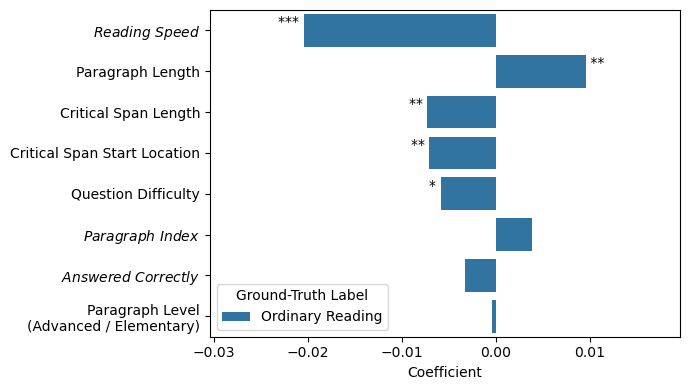

In [17]:
plt.figure(figsize=(7, 4))

# Replace labels for better readability
coeffs_df["label"] = coeffs_df["label"].replace(
    {0: "Ordinary Reading", 1: "Information Seeking"}
)

# Plot the barplot with hue based on the label

palette = {"Ordinary Reading": "tab:blue", "Information Seeking": "tab:red"}

ax = sns.barplot(
    x="Coefficient", y=coeffs_df.index, data=coeffs_df, hue="label", palette=palette
)

# Iterate over the bars to add asterisk annotations
for i, row in enumerate(coeffs_df.itertuples()):
    # Get the value and asterisk for each row
    value = float(row.Coefficient)  # type: ignore
    asterisk = row.asterisk

    # Calculate the y position for correct placement of the asterisk
    y_pos = i  # // 2  # Adjust the position for alternating bars due to the hue

    # Determine if we are annotating for "Ordinary Reading" or "Information Seeking"
    if row.label == "Information Seeking":
        y_pos += 0.2  # Slight adjustment to avoid overlap with the bar
    else:
        y_pos -= 0.2  # Adjust for "Ordinary Reading" label

    # Add the asterisk text to the plot
    if value > 0:
        # For positive values, place asterisk to the right of the bar
        ax.text(value, y_pos, f" {asterisk}", va="center", ha="left")
    else:
        # For negative values, place asterisk to the left of the bar
        ax.text(value, y_pos, f"{asterisk} ", va="center", ha="right")

# plt x range current +- 0.25
plt.xlim(coeffs_df["Coefficient"].min() - 0.01, coeffs_df["Coefficient"].max() + 0.01)

# Set the label for the y-axis and adjust layout
plt.ylabel("")
plt.tight_layout()

# Add legend title: Ground-Truth Label
plt.legend(title="Ground-Truth Label", loc="best")

# Save the figure as a PNG file
plt.savefig("figures/metadata_coeffs.pdf")

# Show the plot
plt.show()

# Coverage-Accuracy Tradeoff

In [11]:
model_df

,subjects,items,label,prediction_prob,eval_regime,fold_index,binary_prediction,is_correct,subject_id_without_list,Participant ID,...,aspan_ind_start,aspan_ind_end,aspan_len,paragraph_length,aspan_start_rel,model_name,a_bcd,level_numeric,is_correct_05,unique_paragraph_id_without_level
3251,l35_118,1_10_Adv_4,0,0.156233,new_item,0,0,1,118,118,...,65,89,24,165,0.393939,RoBERTa-QEye-F,0,1,0.5,1_10__4
3252,l35_85,1_10_Adv_4,1,0.581202,new_item,0,1,1,85,85,...,65,89,24,165,0.393939,RoBERTa-QEye-F,0,1,0.5,1_10__4
3253,l25_56,1_10_Adv_5,1,0.831904,new_item,0,1,1,56,56,...,17,36,19,119,0.142857,RoBERTa-QEye-F,0,1,0.5,1_10__5
3254,l27_108,1_10_Adv_5,0,0.604794,new_item,0,1,0,108,108,...,17,62,45,119,0.142857,RoBERTa-QEye-F,0,1,-0.5,1_10__5
3255,l27_58,1_10_Adv_5,1,0.421305,new_item,0,0,0,58,58,...,17,62,45,119,0.142857,RoBERTa-QEye-F,0,1,-0.5,1_10__5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69971,l24_236,2_10_Ele_1,1,0.991270,new_item_and_subject,9,1,1,236,236,...,9,50,41,105,0.085714,RoBERTa-QEye-F,0,0,0.5,2_10__1
69972,l38_285,2_10_Ele_1,1,1.000000,new_item_and_subject,9,1,1,285,285,...,73,105,32,105,0.695238,RoBERTa-QEye-F,0,0,0.5,2_10__1
69973,l42_308,2_10_Ele_2,0,0.702116,new_item_and_subject,9,1,0,308,308,...,43,87,44,113,0.380531,RoBERTa-QEye-F,0,0,-0.5,2_10__2
69974,l33_391,3_1_Adv_4,1,0.999637,new_item_and_subject,9,1,1,391,391,...,135,151,16,151,0.894040,RoBERTa-QEye-F,1,1,0.5,3_1__4


In [49]:
import numpy as np

res = {}  # tau -> (auccuracy, data coverage)
probs = model_df["prediction_prob"]
labels = model_df["label"]
for tau in np.arange(0, 0.5, 0.003):
    # Calculate coverage
    coverage_mask = (probs >= 0.5 + tau) | (probs <= 0.5 - tau)
    coverage = coverage_mask.mean()

    # accuracy of predictions within the coverage
    # Calculate accuracy of predictions within the coverage
    covered_predictions = probs[coverage_mask]
    covered_labels = labels[coverage_mask]
    predictions = covered_predictions >= 0.5
    accuracy = (predictions == covered_labels).mean()

    res[tau] = (accuracy, coverage)

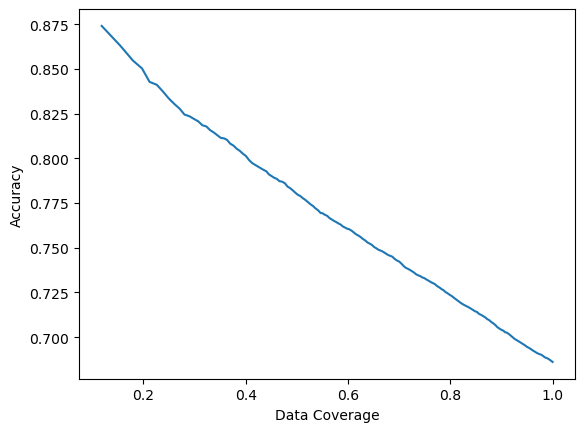

In [50]:
# plot x-coverage, y-accuracy
plt.plot([v[1] for v in res.values()], [v[0] for v in res.values()])
plt.xlabel("Data Coverage")
plt.ylabel("Accuracy")
plt.show()